# ImageNet ViT-S-16 plots

Update the following variables with values corresponding to your own experiments:

In [1]:
# Paths
MODEL_CE_PATH = "../experiments/classification/imagenet/logs/vit16s/version_0/checkpoints/last.ckpt"
MODEL_LS_PATH = "../experiments/classification/imagenet/logs/vit16s_02ls/version_0/checkpoints/last.ckpt"

# Choose your device

DEVICE = "cuda:0"  # or "cpu"

# Whether to save the image or not

SAVE_IMG = False

Prepare the datamodule and disable gradients:

In [2]:
import torch
from torch_uncertainty.datamodules import ImageNetDataModule

# Disable gradients globally
torch.set_grad_enabled(False)

dm = ImageNetDataModule("./data/imagenet1k", batch_size=256, num_workers=8, interpolation="bicubic")
dm.prepare_data()
dm.setup("test")

/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instantiate the models in memory

In [3]:
import torch
from timm.models import vit_small_patch16_224
from torch_uncertainty.datamodules import ImageNetDataModule

model = vit_small_patch16_224(pretrained=False, drop_rate=0.1)
sd = torch.load(MODEL_CE_PATH)["state_dict"]
sd = {k.replace("model.", ""): v for k, v in sd.items()}
model.load_state_dict(sd)
model = model.to(DEVICE)
model = model.eval()

model_ls = vit_small_patch16_224(pretrained=False, drop_rate=0.1)
sd = torch.load(MODEL_LS_PATH)["state_dict"]
sd = {k.replace("model.", ""): v for k, v in sd.items()}
model_ls.load_state_dict(sd)
model_ls = model_ls.to(DEVICE)
model_ls = model_ls.eval()

/tmp/ipykernel_1328036/1750626702.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(MODEL_CE_PATH)["state_dict"]
/tmp/ipykernel_1328036/1750626702.py:13: F

Compute the logits with the CE-based and LS-based models. This may take a few minutes.

In [4]:
from tqdm.auto import tqdm

scores = []
scores_ls = []
correct_samples = []
correct_samples_ls = []

for batch in tqdm(dm.test_dataloader()[0]):
    x, y = batch
    x = x.to(DEVICE)
    y_pred = model(x).softmax(dim=-1).cpu()
    y_pred_ls = model_ls(x).softmax(dim=-1).cpu()
    scores.append(y_pred)
    scores_ls.append(y_pred_ls)
    correct_samples.append(y_pred.argmax(-1) == y)
    correct_samples_ls.append(y_pred_ls.argmax(-1) == y)

scores = torch.cat(scores)
scores_ls = torch.cat(scores_ls)
correct_samples = torch.cat(correct_samples)
correct_samples_ls = torch.cat(correct_samples_ls)

100%|██████████| 196/196 [02:46<00:00,  1.17it/s]


In [5]:
from torch_uncertainty_ls.utils import risk_coverage_curve

ce_risk, ce_cov, thresholds = risk_coverage_curve(correct_samples, scores.max(1).values)
ls_risk, ls_cov, thresholds_ls = risk_coverage_curve(correct_samples_ls, scores_ls.max(1).values)

Create the plots

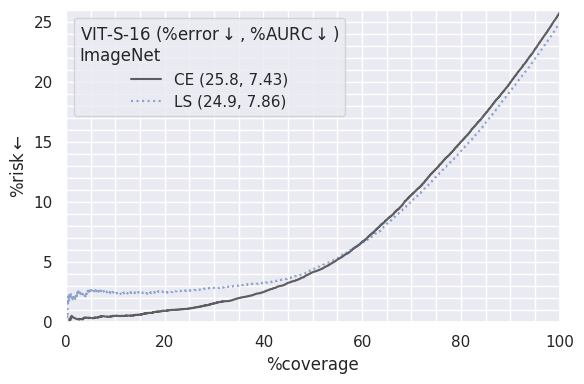

In [6]:
import matplotlib.pyplot as plt
import seaborn

# set the style
seaborn.set_theme()

# Compute and show the risk-coverage curves
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(
    ce_cov * 100,
    ce_risk * 100,
    label=f"CE ({ce_risk[-1]*100:.1f}, {torch.trapz(ce_risk,ce_cov).item()*100:.2f})",
    alpha=0.6,
    color="black",
)
ax.plot(
    ls_cov * 100,
    ls_risk * 100,
    label=f"LS ({ls_risk[-1]*100:.1f}, {torch.trapz(ls_risk, ls_cov).item()*100:.2f})",
    alpha=0.6,
    linestyle="dotted",
)
ax.set_xlabel("%coverage")
ax.set_ylabel("%risk$\leftarrow$")
ax.legend(title="VIT-S-16 (%error$\downarrow$, %AURC$\downarrow$)\nImageNet", loc="upper left")
ax.grid(visible=True, which="both")
ax.set_xlim(0, 100)
ax.set_ylim(0, 26)
ax.minorticks_on()
fig.tight_layout()

if SAVE_IMG:
    plt.savefig("imagenet.pdf", dpi=300)

plt.show();